## L-0 Norm attacks against MNIST

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division
from __future__ import print_function

import sys, os, gc, math
import tensorflow as tf
import numpy as np
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc
from scipy.fftpack import dct,idct


sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from models.neural_network import NeuralNetwork
from models.cnn import CNN
from models.util import *


#Seed used for choosing classes, training points, and test points.
#SEED = 14
SEED=11

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Define params of model
input_shape = (28,28,1)
num_classes = 10

# Load/Create Network and Generate Adversarial Data

In [3]:
#%%capture one
#Load model from disk
model_name = 'MNIST-L0'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='mnist', transform='dct',seed=SEED,project='False')
print ('Total Model Params: %d' % model.num_params)
model.load_model(model_save_path, weights_save_path) 
#epochs = 20
#model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)    

../models/neural_network.py:129: ComplexWarning: Casting complex values to real discards the imaginary part
  x_rec[i,:,:,0]= f_recon


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Total Model Params: 1199882
Loaded model from disk


In [4]:
#Model Accuracy
print ('Model Accuracy: %.5f' % (model.model.evaluate(model.val_data, model.val_labels)[1]))

10000/10000 [==============================] - 1s 96us/step
Model Accuracy: 0.99140


In [4]:
%%capture two
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=int(model.train_data.shape[0]/2), high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

**GREYBOX ATTACKS**

In [5]:
%%capture three
num_test_samples_per_class = 100
num_test_samples = num_classes*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

In [7]:
%%capture four
import time
#Get Regular, JSMA, DF, and CW test points
reg_data = model.test_data[test_indices]
start_time = time.time()
jsma_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='JSMA', iterations=100)
print("--- JSMA: %s seconds ---" % (time.time() - start_time))
start_time = time.time()
cwl0_data = model.generate_perturbed_data(model.test_data[test_indices], seed=SEED, perturbation='CW-l0')
print("--- CW: %s seconds ---" % (time.time() - start_time))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [6]:
%%capture five
reg_data = np.load('data/reg_data_mnist_l0.npy')
jsma_data = np.load('data/jsma_data_mnist_l0.npy')
cwl0_data = np.load('data/cwl0_data_mnist_l0.npy')


In [8]:
#%%capture five
#np.save('data/reg_data_mnist_l0', reg_data)
#np.save('data/jsma_data_mnist_l0', jsma_data)
#np.save('data/cwl0_data_mnist_l0', cwl0_data)

In [7]:
print ('Model Accuracy REG: %.5f' % (model.model.evaluate(reg_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy CW-l0: %.5f' % (model.model.evaluate(cwl0_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy JSMA: %.5f' % (model.model.evaluate(jsma_data,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 1s 1ms/step
Model Accuracy REG: 0.98800
1000/1000 [==============================] - 0s 92us/step
Model Accuracy CW-l0: 0.01000
1000/1000 [==============================] - 0s 93us/step
Model Accuracy JSMA: 0.56500


Training Data: 


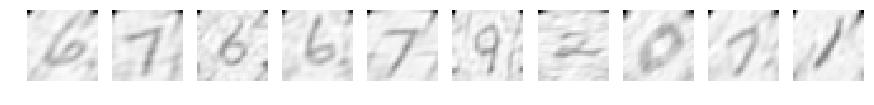

In [12]:
#Lets visualize training data
x_vis = np.random.choice(range(0,num_train_samples), 10)
print ('Training Data: ')
visualize(train_data[x_vis].reshape(-1,*input_shape), 10, '../figures/train-mnist_l0')

Regular: 


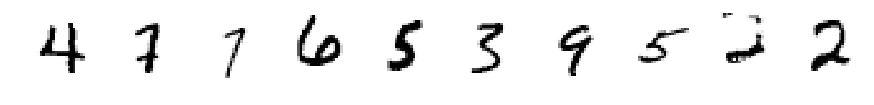

CW-l0: 


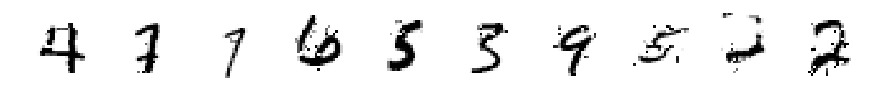

JSMA: 


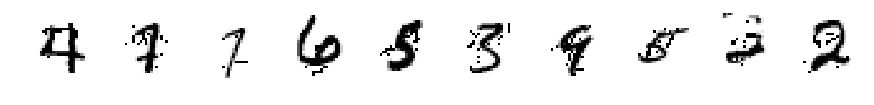

In [18]:
#Lets visualize samples from each attack
x_vis = np.random.choice(range(0,num_test_samples), 10)
print ('Regular: ')
visualize(reg_data[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-mnist_l0')
print ('CW-l0: ')
visualize(cwl0_data[x_vis].reshape(-1,*input_shape), 10, '../figures/cwl0-mnist_l0')
print ('JSMA: ')
visualize(jsma_data[x_vis].reshape(-1,*input_shape), 10, '../figures/jsma-mnist_l0')

In [8]:
%%capture seven
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,*input_shape))
cwl0_preds = model.model.predict(cwl0_data.reshape(-1,*input_shape))
jsma_preds = model.model.predict(jsma_data.reshape(-1,*input_shape))

#Convert preds to labels
reg_labels = preds_to_labels(reg_preds)
cwl0_labels = preds_to_labels(cwl0_preds)
jsma_labels = preds_to_labels(jsma_preds)

#Select Adversarial Points (i.e. points that lead to misclassification)
true_preds = np.argmax(model.test_labels[test_indices], axis=1)

#Check which points are actually adversarial and select those
cwl0_idx = np.where(np.argmax(cwl0_preds, axis=1) != true_preds)[0]
jsma_idx = np.where(np.argmax(jsma_preds, axis=1) != true_preds)[0]


#Filter data points to be used for similarity
cwl0_data_fil = cwl0_data[cwl0_idx]
jsma_data_fil = jsma_data[jsma_idx]


#Filter labels to be used
cwl0_labels_fil = cwl0_labels[cwl0_idx]
jsma_labels_fil = jsma_labels[jsma_idx]

In [9]:
#Get l-0 distortion 
print ('CW-l0: %.5f' % (avg_l0_dist(reg_data[cwl0_idx], cwl0_data_fil)))
print ('JSMA: %.5f' % (avg_l0_dist(reg_data[jsma_idx], jsma_data_fil)))

CW-l0: 15.00000
JSMA: 17.00000


In [10]:
clean_reg = np.zeros(jsma_data.shape)
for i in range(num_test_samples):
    x_adv = reg_data[i,:,:,0]
    x_hat = dct(x_adv.flatten(),norm='ortho')
    x_hat = get_topk_vec(x_hat,k=40)
    clean_reg[i,:,:,0] = idct(x_hat.flatten(),norm='ortho').reshape(28,28)

In [11]:
avg=0.0
ratios = []
for i,j in enumerate(cwl0_idx):
    r = np.linalg.norm(reg_data[j]-cwl0_data_fil[i])/np.linalg.norm(reg_data[j])
    ratios.append(r)
    avg+=r
print(avg/1000, max(ratios), min(ratios))

0.2688933374537155 0.6957838 0.005288164


In [12]:
avg=0.0
ratios = []
for i,j in enumerate(jsma_idx):
    r = np.linalg.norm(reg_data[j]-jsma_data_fil[i])/np.linalg.norm(reg_data[j])
    ratios.append(r)
    avg+=r
print(avg/1000, max(ratios), min(ratios))

0.1985166515931487 1.0203296 0.104976095


# IHT Reconstruction

In [13]:
%%capture eleven
#Reconstruct CW-l0
t=20
clean_cwl0_iht = np.zeros(cwl0_data.shape)
for i in range(num_test_samples):
    x_adv = cwl0_data[i,:,:,0].flatten()
    x_hat,_ = iht(x_adv,t, T=100,k=40)
    clean_cwl0_iht[i,:,:,0]= idct(x_hat.flatten(),norm='ortho').reshape(28,28)

In [14]:
%%capture twelve
#Reconstruct JSMA-l0
t=20
clean_jsma_iht = np.zeros(cwl0_data.shape)
for i in range(num_test_samples):
    x_adv = jsma_data[i,:,:,0].flatten()
    x_hat,_ = iht(x_adv,t, T=100,k=40)
    clean_jsma_iht[i,:,:,0]= idct(x_hat.flatten(),norm='ortho').reshape(28,28)

In [15]:
%%capture thirteen
np.save('data/clean_mnist_cwl0_l0-iht', clean_cwl0_iht)
np.save('data/clean_mnist_jsma_l0-iht', clean_jsma_iht)

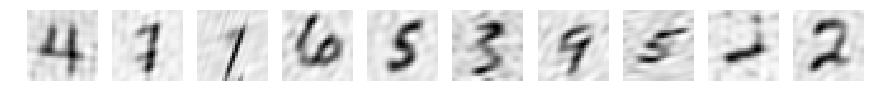

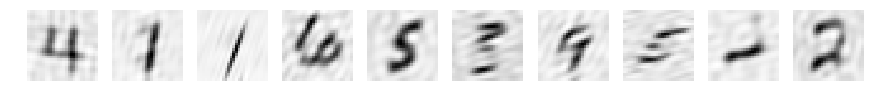

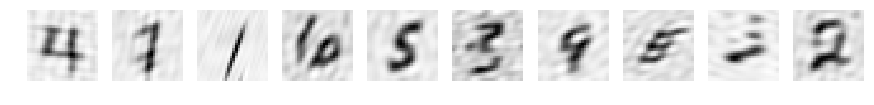

In [19]:
visualize(clean_reg[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-test-mnist_l0')
visualize(clean_cwl0_iht[x_vis].reshape(-1,*input_shape), 10, '../figures/cwl0-clean-mnist_l0-iht')
visualize(clean_jsma_iht[x_vis].reshape(-1,*input_shape), 10, '../figures/jsma-clean-mnist_l0-iht')

In [20]:
print ('Model Accuracy Reconstructed CW-l0: %.5f' % (model.model.evaluate(clean_cwl0_iht,model.test_labels[test_indices])[1]))
print ('Model Accuracy Reconstructed JSMA: %.5f' % (model.model.evaluate(clean_jsma_iht,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 0s 91us/step
Model Accuracy Reconstructed CW-l0: 0.84200
1000/1000 [==============================] - 0s 79us/step
Model Accuracy Reconstructed JSMA: 0.90100


# BP Reconstruction

In [21]:
D = get_matrix(28*28)
A = np.concatenate((D.T,np.identity(28*28)),axis=1)

In [ ]:
%%capture thirteen
#Reconstruct CW-l0
clean_cwl0_socp = np.zeros(cwl0_data.shape)
for i in range(100):
    x_adv = cwl0_data[i,:,:,0].flatten()
    x_hat_orig = dct(reg_data[i,:,:,0].flatten(),norm='ortho')
    #Can experiment with values of k that will lead to diff values of eta.
    x_top,x_bot = get_top_bot_k_vec(x_hat_orig,k=784) 
    eta = np.linalg.norm(x_bot)
    x_hat = socp(x_adv,A, n=28*28*2,eta=eta)[:784]
    x_hat_top,_ = get_top_bot_k_vec(x_hat,k=40)
    clean_cwl0_socp[i,:,:,0]= idct(x_hat_top.flatten(),norm='ortho').reshape(28,28)

In [ ]:
%%capture fourteen
#Reconstruct CW-l0
clean_jsma_socp = np.zeros(jsma_data.shape)
for i in range(num_test_samples):
    x_adv = jsma_data[i,:,:,0].flatten()
    x_hat_orig = dct(reg_data[i,:,:,0].flatten(),norm='ortho')
    x_top,x_bot = get_top_bot_k_vec(x_hat_orig,k=784)
    eta = np.linalg.norm(x_bot)
    x_hat = socp(x_adv,A, n=28*28*2,eta=eta)[:784]
    x_hat_top,_ = get_top_bot_k_vec(x_hat,k=40)
    clean_jsma_socp[i,:,:,0]= idct(x_hat_top.flatten(),norm='ortho').reshape(28,28)

In [ ]:
%%capture fifteen
np.save('data/clean_mnist_cwl0_l0-socp', clean_cwl0_socp)
np.save('data/clean_mnist_jsma_l0-socp', clean_jsma_socp)

In [ ]:
visualize(clean_reg[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-test-mnist_l0')
visualize(clean_cwl0_socp[x_vis].reshape(-1,*input_shape), 10, '../figures/cwl0-clean-mnist_l0-socp')
visualize(clean_jsma_socp[x_vis].reshape(-1,*input_shape), 10, '../figures/jsma-clean-mnist_l0-socp')

In [ ]:
print ('Model Accuracy Reconstructed CW-l0: %.5f' % (model.model.evaluate(clean_cwl0_socp,model.test_labels[test_indices])[1]))
print ('Model Accuracy Reconstructed JSMA: %.5f' % (model.model.evaluate(clean_jsma_socp,model.test_labels[test_indices])[1]))